### Deep learning model training.


In [1]:
import time
import torch
import random
import pandas as pd
import torch.nn as nn
from glob import glob
from model import u2net 
import geopandas as gpd 
from notebooks import config
import torch.nn.functional as F
from utils.imgShow import imsShow
from utils.utils import read_scenes
from utils.metrics import oa_binary, miou_binary
from utils.dataloader import SceneArraySet,PatchPathSet, PatchPathSet_2
from model import unet, deeplabv3plus, deeplabv3plus_mobilev2, u2net


In [2]:
patch_size = 768  ## patch size setting
patch_resize = None  ## patch resize setting
### traset
paths_scene_tra, paths_truth_tra = config.paths_scene_tra, config.paths_truth_tra
paths_dem_tra = config.paths_dem_tra
# paths_dem_tra = config.paths_dem_adjust_tra
print(f'train scenes: {len(paths_scene_tra)}')
### valset
paths_valset = sorted(glob(f'data/dset/valset/patch_{patch_size}/*'))  ## for model prediction 
# paths_patch_valset = sorted(glob(f'data/dset/valset/patch_{patch_size}_dem_adjust/*'))
print(f'vali patch {patch_size}: {len(paths_valset)}')



train scenes: 48
vali patch 768: 293


### dataset loading

In [3]:
scenes_arr, truths_arr = read_scenes(paths_scene_tra, 
                                     paths_truth_tra, 
                                     paths_dem_tra) 


In [4]:
## Create dataset instances
tra_data = SceneArraySet(scenes_arr=scenes_arr, 
                         truths_arr=truths_arr, 
                         patch_size=patch_size,
                         patch_resize=patch_resize)
val_data = PatchPathSet_2(paths_valset=paths_valset, 
                          patch_resize=patch_resize)
tra_loader = torch.utils.data.DataLoader(tra_data, 
                                         batch_size=4, 
                                         shuffle=True, 
                                         num_workers=10)
val_loader = torch.utils.data.DataLoader(val_data, 
                                         batch_size=4, 
                                         num_workers=10)


#### Model training

In [5]:
### check model
model = unet(num_bands=7)
# model = u2net(num_bands_b1=6, num_bands_b2=1)
# model = deeplabv3plus(num_bands=7)
# model = deeplabv3plus_mobilev2(num_bands=7)

In [6]:
tensor = torch.randn(2, 7, 512, 512)
output = model(tensor)
print(output.shape) 


torch.Size([2, 1, 512, 512])


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.4, gamma=3.0, reduction='mean', eps=1e-8):
        super(BinaryFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.eps = eps

    def forward(self, pred_prob, target_prob):
        pred_prob = torch.clamp(pred_prob, self.eps, 1 - self.eps)        
        bce = - (target_prob * torch.log(pred_prob) + 
                  (1 - target_prob) * torch.log(1 - pred_prob))
        
        pt = torch.where(target_prob == 1, pred_prob, 1 - pred_prob)
        modulating_factor = (1 - pt) ** self.gamma
        alpha_factor = torch.where(target_prob == 1, self.alpha, 1 - self.alpha)
        loss = alpha_factor * modulating_factor * bce
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:  # 'none'
            return loss

loss_focal = BinaryFocalLoss()

In [8]:
### create loss and optimizer
loss_bce = nn.BCELoss()     
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, \
                                          mode='min', factor=0.6, patience=20) 


In [9]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y, device=x.device)
    oa = oa_binary(pred=pred, truth=y, device=x.device)
    return loss, miou, oa

'''------validation step------'''
def val_step(model, loss_fn, x, y, patch_size, patch_resize):
    model.eval()
    with torch.no_grad():
        pred = model(x.float())
        if patch_size > 256:
            if patch_resize == 256:
                pred = F.interpolate(pred, 
                                size=(patch_size, patch_size), 
                                mode='bilinear',
                                align_corners=True)
            crop_start = (patch_size-256)//2
            pred = pred[:, :, crop_start:crop_start+256, crop_start:crop_start+256]  ## crop to match the size
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y, device=x.device)
    oa = oa_binary(pred=pred, truth=y, device=x.device)
    return loss, miou, oa

'''------train loops------'''
def train_loops(model, loss_fn, optimizer, 
                    tra_loader, val_loader, epoches, 
                    device, patch_size, patch_resize,
                    lr_scheduler=None):
    tra_loss_loops, tra_miou_loops, tra_oa_loops = [], [], []
    val_loss_loops, val_miou_loops, val_oa_loops = [], [], []
    model = model.to(device)
    size_tra_loader = len(tra_loader)
    size_val_loader = len(val_loader)
    for epoch in range(epoches):
        start = time.time()
        tra_loss, val_loss = 0, 0
        tra_miou, val_miou = 0, 0
        tra_oa, val_oa = 0, 0
        '''-----train the model-----'''
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                    optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        if lr_scheduler:
          lr_scheduler.step(tra_loss)    # if using ReduceLROnPlateau
        '''----- validation the model: time consuming -----'''
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            loss, miou, oa = val_step(model=model, 
                                        loss_fn=loss_fn, 
                                        x=x_batch, 
                                        y=y_batch, 
                                        patch_size=patch_size, 
                                        patch_resize=patch_resize)
            val_loss += loss.item()
            val_miou += miou.item()
            val_oa += oa.item()
        ## Accuracy
        tra_loss = tra_loss/size_tra_loader
        val_loss = val_loss/size_val_loader
        tra_miou = tra_miou/size_tra_loader
        val_miou = val_miou/size_val_loader
        tra_oa = tra_oa/size_tra_loader
        val_oa = val_oa/size_val_loader
        tra_loss_loops.append(tra_loss); tra_miou_loops.append(tra_miou); tra_oa_loops.append(tra_oa)
        val_loss_loops.append(val_loss); val_miou_loops.append(val_miou); val_oa_loops.append(val_oa)
        print(f'Ep{epoch+1}: tra-> Loss:{tra_loss:.3f},Oa:{tra_oa:.3f},Miou:{tra_miou:.3f}, '
                f'val-> Loss:{val_loss:.3f},Oa:{val_oa:.3f}, Miou:{val_miou:.3f},time:{time.time()-start:.1f}s')
        ## show the result
        if (epoch+1)%20 == 0:
            model.eval()
            sam_index = random.randrange(len(val_data))
            patch, truth = val_data[sam_index]
            patch, truth = torch.unsqueeze(patch.float(), 0).to(device), truth.to(device)
            pred = model(patch)
            if patch_size > 256:
                if patch_resize == 256:
                    pred = F.interpolate(pred, 
                                    size=(patch_size, patch_size), 
                                    mode='bilinear',
                                    align_corners=True)
                crop_start = (patch_size-256)//2
                pred = pred[:, :, crop_start:crop_start+256, crop_start:crop_start+256]  ## crop to match the size
            ## convert to numpy and plot
            patch = patch[0].to('cpu').detach().numpy().transpose(1,2,0)
            pdem = patch[:,:, -1]
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            imsShow([patch, pdem, truth, pred], 
                    clip_list = (2,2,0,0),
                    img_name_list=['input_patch', 'pdem', 'truth', 'prediction'],                     
                    figsize=(13,3))
    metrics = {'tra_loss':tra_loss_loops, 'tra_miou':tra_miou_loops, 'tra_oa': tra_oa_loops, 
                'val_loss': val_loss_loops, 'val_miou': val_miou_loops, 'val_oa': val_oa_loops}
    return metrics 


Ep1: tra-> Loss:0.024,Oa:0.802,Miou:0.694, val-> Loss:0.034,Oa:0.394, Miou:0.320,time:3.9s
Ep2: tra-> Loss:0.022,Oa:0.776,Miou:0.586, val-> Loss:0.020,Oa:0.815, Miou:0.649,time:3.8s
Ep3: tra-> Loss:0.013,Oa:0.917,Miou:0.856, val-> Loss:0.012,Oa:0.865, Miou:0.771,time:3.7s
Ep4: tra-> Loss:0.008,Oa:0.914,Miou:0.862, val-> Loss:0.015,Oa:0.859, Miou:0.736,time:3.6s
Ep5: tra-> Loss:0.008,Oa:0.918,Miou:0.860, val-> Loss:0.011,Oa:0.869, Miou:0.775,time:3.3s
Ep6: tra-> Loss:0.009,Oa:0.939,Miou:0.884, val-> Loss:0.010,Oa:0.871, Miou:0.783,time:3.2s
Ep7: tra-> Loss:0.008,Oa:0.923,Miou:0.871, val-> Loss:0.011,Oa:0.871, Miou:0.777,time:3.8s
Ep8: tra-> Loss:0.006,Oa:0.951,Miou:0.889, val-> Loss:0.010,Oa:0.874, Miou:0.788,time:3.4s
Ep9: tra-> Loss:0.006,Oa:0.957,Miou:0.921, val-> Loss:0.010,Oa:0.886, Miou:0.797,time:3.5s
Ep10: tra-> Loss:0.008,Oa:0.932,Miou:0.864, val-> Loss:0.013,Oa:0.873, Miou:0.757,time:3.5s
Ep11: tra-> Loss:0.008,Oa:0.942,Miou:0.877, val-> Loss:0.010,Oa:0.885, Miou:0.799,time:3.

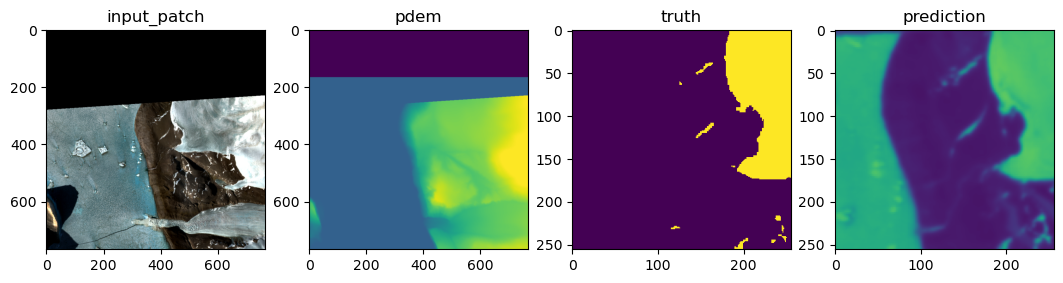

Ep21: tra-> Loss:0.007,Oa:0.943,Miou:0.896, val-> Loss:0.009,Oa:0.892, Miou:0.810,time:3.7s
Ep22: tra-> Loss:0.005,Oa:0.964,Miou:0.925, val-> Loss:0.010,Oa:0.896, Miou:0.821,time:3.6s
Ep23: tra-> Loss:0.005,Oa:0.940,Miou:0.908, val-> Loss:0.010,Oa:0.896, Miou:0.816,time:3.6s
Ep24: tra-> Loss:0.004,Oa:0.977,Miou:0.947, val-> Loss:0.012,Oa:0.893, Miou:0.815,time:3.4s
Ep25: tra-> Loss:0.005,Oa:0.951,Miou:0.914, val-> Loss:0.010,Oa:0.897, Miou:0.815,time:3.3s
Ep26: tra-> Loss:0.008,Oa:0.919,Miou:0.862, val-> Loss:0.011,Oa:0.883, Miou:0.815,time:3.4s
Ep27: tra-> Loss:0.006,Oa:0.915,Miou:0.886, val-> Loss:0.011,Oa:0.894, Miou:0.815,time:3.6s
Ep28: tra-> Loss:0.007,Oa:0.934,Miou:0.890, val-> Loss:0.009,Oa:0.893, Miou:0.816,time:3.6s
Ep29: tra-> Loss:0.006,Oa:0.885,Miou:0.850, val-> Loss:0.009,Oa:0.894, Miou:0.809,time:3.5s
Ep30: tra-> Loss:0.006,Oa:0.963,Miou:0.902, val-> Loss:0.009,Oa:0.898, Miou:0.816,time:3.4s
Ep31: tra-> Loss:0.006,Oa:0.939,Miou:0.904, val-> Loss:0.009,Oa:0.895, Miou:0.81

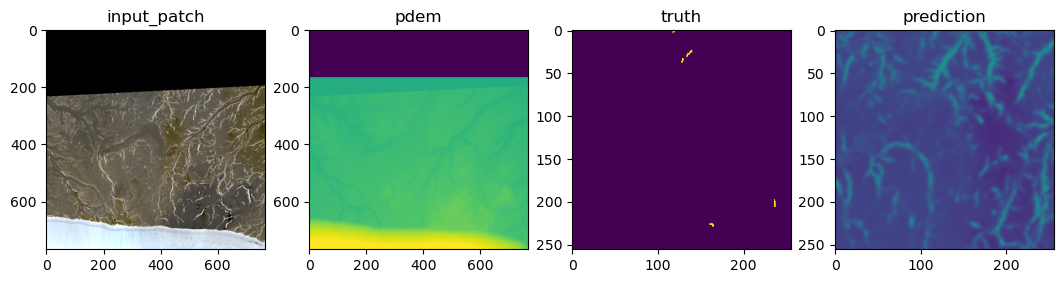

Ep41: tra-> Loss:0.005,Oa:0.957,Miou:0.921, val-> Loss:0.009,Oa:0.898, Miou:0.832,time:3.5s
Ep42: tra-> Loss:0.003,Oa:0.966,Miou:0.931, val-> Loss:0.010,Oa:0.895, Miou:0.831,time:3.6s
Ep43: tra-> Loss:0.005,Oa:0.967,Miou:0.928, val-> Loss:0.008,Oa:0.901, Miou:0.834,time:3.6s
Ep44: tra-> Loss:0.004,Oa:0.954,Miou:0.923, val-> Loss:0.009,Oa:0.902, Miou:0.836,time:3.4s
Ep45: tra-> Loss:0.006,Oa:0.940,Miou:0.905, val-> Loss:0.008,Oa:0.908, Miou:0.836,time:3.5s
Ep46: tra-> Loss:0.004,Oa:0.970,Miou:0.936, val-> Loss:0.009,Oa:0.895, Miou:0.829,time:3.4s
Ep47: tra-> Loss:0.006,Oa:0.944,Miou:0.886, val-> Loss:0.008,Oa:0.909, Miou:0.829,time:3.4s
Ep48: tra-> Loss:0.005,Oa:0.942,Miou:0.912, val-> Loss:0.010,Oa:0.895, Miou:0.830,time:3.3s
Ep49: tra-> Loss:0.005,Oa:0.951,Miou:0.914, val-> Loss:0.008,Oa:0.906, Miou:0.830,time:3.6s
Ep50: tra-> Loss:0.005,Oa:0.964,Miou:0.921, val-> Loss:0.008,Oa:0.899, Miou:0.832,time:3.2s
Ep51: tra-> Loss:0.005,Oa:0.965,Miou:0.916, val-> Loss:0.009,Oa:0.904, Miou:0.83

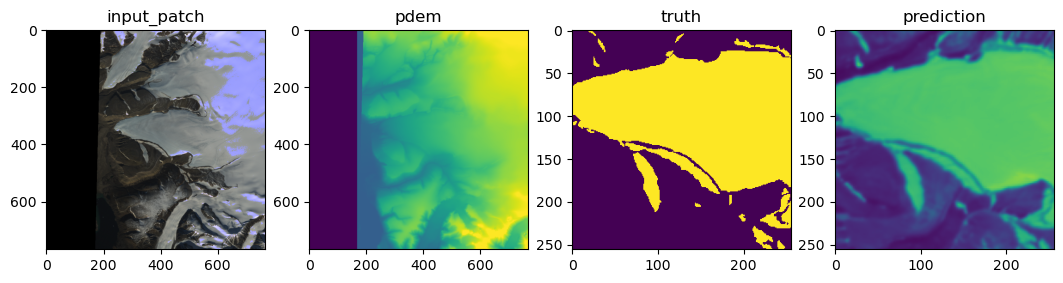

Ep61: tra-> Loss:0.005,Oa:0.960,Miou:0.932, val-> Loss:0.007,Oa:0.920, Miou:0.855,time:2.7s
Ep62: tra-> Loss:0.005,Oa:0.947,Miou:0.924, val-> Loss:0.006,Oa:0.911, Miou:0.854,time:2.8s
Ep63: tra-> Loss:0.004,Oa:0.958,Miou:0.922, val-> Loss:0.007,Oa:0.908, Miou:0.852,time:2.7s
Ep64: tra-> Loss:0.005,Oa:0.942,Miou:0.893, val-> Loss:0.006,Oa:0.923, Miou:0.860,time:2.7s
Ep65: tra-> Loss:0.005,Oa:0.947,Miou:0.914, val-> Loss:0.007,Oa:0.894, Miou:0.840,time:2.8s
Ep66: tra-> Loss:0.004,Oa:0.940,Miou:0.918, val-> Loss:0.008,Oa:0.901, Miou:0.838,time:2.7s
Ep67: tra-> Loss:0.005,Oa:0.953,Miou:0.910, val-> Loss:0.006,Oa:0.912, Miou:0.846,time:2.9s
Ep68: tra-> Loss:0.004,Oa:0.946,Miou:0.918, val-> Loss:0.006,Oa:0.916, Miou:0.849,time:2.7s
Ep69: tra-> Loss:0.004,Oa:0.963,Miou:0.924, val-> Loss:0.006,Oa:0.922, Miou:0.856,time:2.9s
Ep70: tra-> Loss:0.003,Oa:0.978,Miou:0.948, val-> Loss:0.007,Oa:0.906, Miou:0.849,time:2.7s
Ep71: tra-> Loss:0.004,Oa:0.945,Miou:0.898, val-> Loss:0.010,Oa:0.894, Miou:0.80

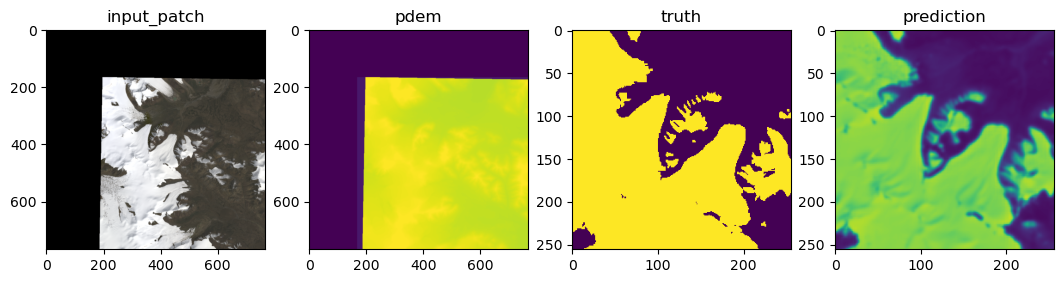

Ep81: tra-> Loss:0.004,Oa:0.972,Miou:0.944, val-> Loss:0.006,Oa:0.909, Miou:0.855,time:2.7s
Ep82: tra-> Loss:0.004,Oa:0.956,Miou:0.920, val-> Loss:0.005,Oa:0.915, Miou:0.866,time:2.7s
Ep83: tra-> Loss:0.004,Oa:0.944,Miou:0.898, val-> Loss:0.005,Oa:0.910, Miou:0.862,time:2.9s
Ep84: tra-> Loss:0.005,Oa:0.962,Miou:0.927, val-> Loss:0.007,Oa:0.906, Miou:0.833,time:2.8s
Ep85: tra-> Loss:0.004,Oa:0.962,Miou:0.929, val-> Loss:0.006,Oa:0.914, Miou:0.848,time:2.7s
Ep86: tra-> Loss:0.004,Oa:0.935,Miou:0.909, val-> Loss:0.005,Oa:0.926, Miou:0.872,time:2.7s
Ep87: tra-> Loss:0.004,Oa:0.972,Miou:0.932, val-> Loss:0.008,Oa:0.896, Miou:0.841,time:2.8s
Ep88: tra-> Loss:0.004,Oa:0.961,Miou:0.927, val-> Loss:0.007,Oa:0.916, Miou:0.849,time:2.8s
Ep89: tra-> Loss:0.004,Oa:0.955,Miou:0.916, val-> Loss:0.006,Oa:0.914, Miou:0.857,time:2.8s
Ep90: tra-> Loss:0.003,Oa:0.960,Miou:0.924, val-> Loss:0.006,Oa:0.922, Miou:0.862,time:2.9s
Ep91: tra-> Loss:0.004,Oa:0.978,Miou:0.951, val-> Loss:0.006,Oa:0.913, Miou:0.86

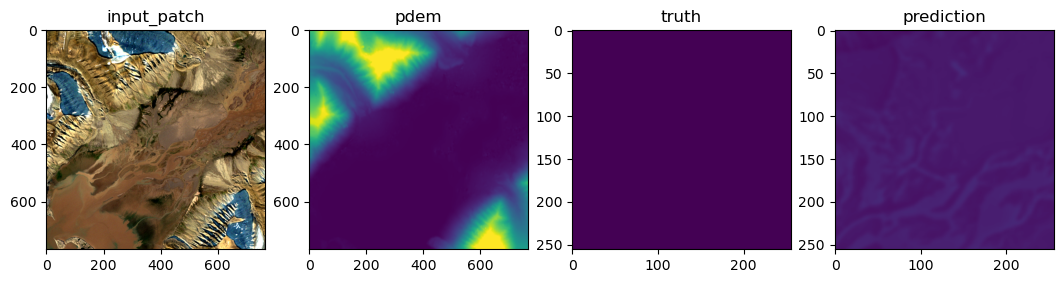

Ep101: tra-> Loss:0.004,Oa:0.970,Miou:0.919, val-> Loss:0.005,Oa:0.927, Miou:0.873,time:2.8s
Ep102: tra-> Loss:0.004,Oa:0.967,Miou:0.929, val-> Loss:0.005,Oa:0.925, Miou:0.865,time:2.8s
Ep103: tra-> Loss:0.004,Oa:0.978,Miou:0.938, val-> Loss:0.005,Oa:0.937, Miou:0.884,time:2.8s
Ep104: tra-> Loss:0.003,Oa:0.980,Miou:0.949, val-> Loss:0.006,Oa:0.926, Miou:0.856,time:2.7s
Ep105: tra-> Loss:0.003,Oa:0.975,Miou:0.951, val-> Loss:0.006,Oa:0.917, Miou:0.865,time:2.8s
Ep106: tra-> Loss:0.005,Oa:0.964,Miou:0.930, val-> Loss:0.005,Oa:0.935, Miou:0.869,time:2.8s
Ep107: tra-> Loss:0.005,Oa:0.967,Miou:0.921, val-> Loss:0.006,Oa:0.901, Miou:0.842,time:2.8s
Ep108: tra-> Loss:0.004,Oa:0.962,Miou:0.922, val-> Loss:0.005,Oa:0.917, Miou:0.869,time:2.9s
Ep109: tra-> Loss:0.003,Oa:0.974,Miou:0.945, val-> Loss:0.005,Oa:0.924, Miou:0.874,time:2.7s
Ep110: tra-> Loss:0.003,Oa:0.966,Miou:0.937, val-> Loss:0.006,Oa:0.914, Miou:0.855,time:2.7s
Ep111: tra-> Loss:0.005,Oa:0.972,Miou:0.920, val-> Loss:0.005,Oa:0.925

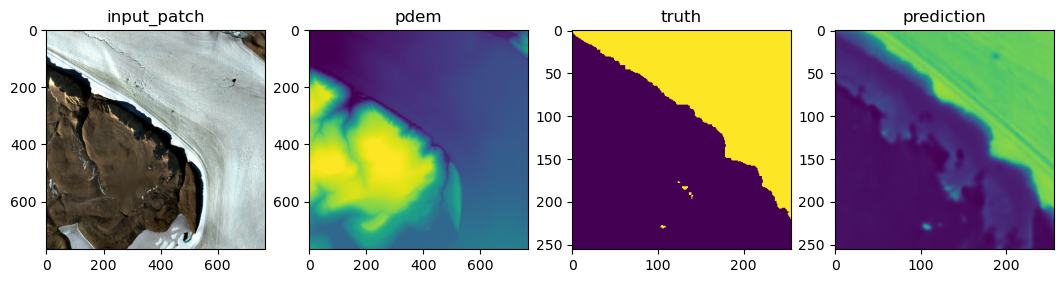

Ep121: tra-> Loss:0.003,Oa:0.975,Miou:0.945, val-> Loss:0.005,Oa:0.935, Miou:0.869,time:2.8s
Ep122: tra-> Loss:0.003,Oa:0.967,Miou:0.926, val-> Loss:0.004,Oa:0.934, Miou:0.885,time:2.8s
Ep123: tra-> Loss:0.002,Oa:0.977,Miou:0.956, val-> Loss:0.005,Oa:0.937, Miou:0.888,time:2.7s
Ep124: tra-> Loss:0.003,Oa:0.983,Miou:0.949, val-> Loss:0.005,Oa:0.935, Miou:0.887,time:2.8s
Ep125: tra-> Loss:0.003,Oa:0.974,Miou:0.949, val-> Loss:0.006,Oa:0.926, Miou:0.858,time:2.7s
Ep126: tra-> Loss:0.004,Oa:0.970,Miou:0.925, val-> Loss:0.005,Oa:0.932, Miou:0.885,time:2.8s
Ep127: tra-> Loss:0.003,Oa:0.980,Miou:0.951, val-> Loss:0.006,Oa:0.925, Miou:0.854,time:2.8s
Ep128: tra-> Loss:0.003,Oa:0.983,Miou:0.953, val-> Loss:0.005,Oa:0.934, Miou:0.870,time:2.7s
Ep129: tra-> Loss:0.002,Oa:0.980,Miou:0.956, val-> Loss:0.005,Oa:0.935, Miou:0.888,time:2.7s
Ep130: tra-> Loss:0.003,Oa:0.964,Miou:0.939, val-> Loss:0.005,Oa:0.935, Miou:0.867,time:2.8s
Ep131: tra-> Loss:0.003,Oa:0.974,Miou:0.940, val-> Loss:0.005,Oa:0.925

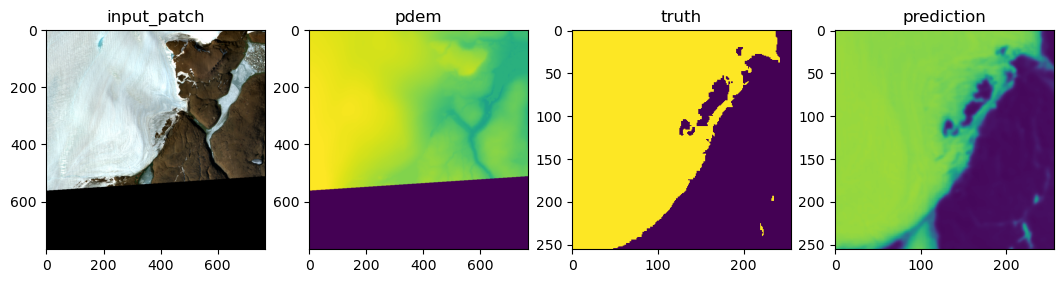

Ep141: tra-> Loss:0.003,Oa:0.977,Miou:0.946, val-> Loss:0.006,Oa:0.913, Miou:0.854,time:2.9s
Ep142: tra-> Loss:0.003,Oa:0.965,Miou:0.934, val-> Loss:0.006,Oa:0.917, Miou:0.857,time:2.8s
Ep143: tra-> Loss:0.003,Oa:0.965,Miou:0.942, val-> Loss:0.006,Oa:0.922, Miou:0.863,time:2.7s
Ep144: tra-> Loss:0.003,Oa:0.977,Miou:0.953, val-> Loss:0.006,Oa:0.933, Miou:0.874,time:2.7s
Ep145: tra-> Loss:0.002,Oa:0.983,Miou:0.952, val-> Loss:0.005,Oa:0.931, Miou:0.875,time:2.8s
Ep146: tra-> Loss:0.002,Oa:0.973,Miou:0.940, val-> Loss:0.005,Oa:0.928, Miou:0.871,time:2.7s
Ep147: tra-> Loss:0.002,Oa:0.973,Miou:0.948, val-> Loss:0.005,Oa:0.922, Miou:0.864,time:2.8s
Ep148: tra-> Loss:0.002,Oa:0.980,Miou:0.952, val-> Loss:0.006,Oa:0.936, Miou:0.873,time:2.8s
Ep149: tra-> Loss:0.003,Oa:0.980,Miou:0.956, val-> Loss:0.005,Oa:0.931, Miou:0.876,time:2.9s
Ep150: tra-> Loss:0.003,Oa:0.977,Miou:0.948, val-> Loss:0.006,Oa:0.936, Miou:0.879,time:2.8s
Ep151: tra-> Loss:0.003,Oa:0.980,Miou:0.955, val-> Loss:0.006,Oa:0.935

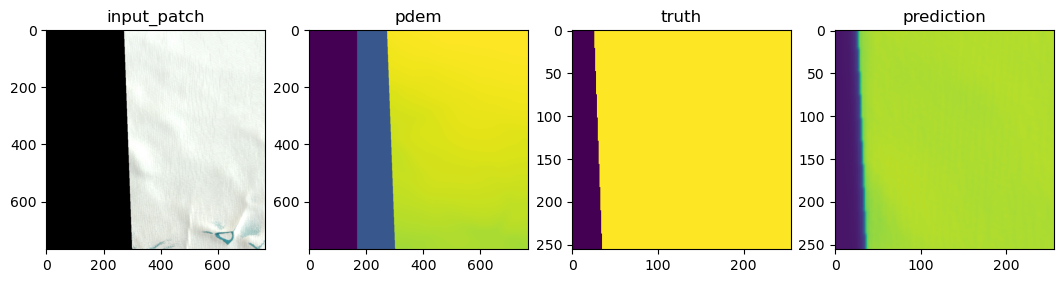

Ep161: tra-> Loss:0.002,Oa:0.982,Miou:0.956, val-> Loss:0.005,Oa:0.936, Miou:0.877,time:2.8s
Ep162: tra-> Loss:0.003,Oa:0.980,Miou:0.956, val-> Loss:0.005,Oa:0.934, Miou:0.878,time:2.7s
Ep163: tra-> Loss:0.002,Oa:0.962,Miou:0.930, val-> Loss:0.005,Oa:0.936, Miou:0.880,time:2.7s
Ep164: tra-> Loss:0.002,Oa:0.981,Miou:0.953, val-> Loss:0.005,Oa:0.935, Miou:0.881,time:2.7s
Ep165: tra-> Loss:0.003,Oa:0.976,Miou:0.944, val-> Loss:0.005,Oa:0.937, Miou:0.878,time:2.8s
Ep166: tra-> Loss:0.002,Oa:0.983,Miou:0.959, val-> Loss:0.005,Oa:0.928, Miou:0.874,time:2.7s
Ep167: tra-> Loss:0.002,Oa:0.986,Miou:0.966, val-> Loss:0.005,Oa:0.935, Miou:0.869,time:2.8s
Ep168: tra-> Loss:0.003,Oa:0.971,Miou:0.926, val-> Loss:0.005,Oa:0.931, Miou:0.880,time:2.7s
Ep169: tra-> Loss:0.003,Oa:0.973,Miou:0.943, val-> Loss:0.006,Oa:0.935, Miou:0.862,time:2.9s
Ep170: tra-> Loss:0.002,Oa:0.979,Miou:0.952, val-> Loss:0.004,Oa:0.935, Miou:0.884,time:2.8s
Ep171: tra-> Loss:0.002,Oa:0.984,Miou:0.958, val-> Loss:0.005,Oa:0.936

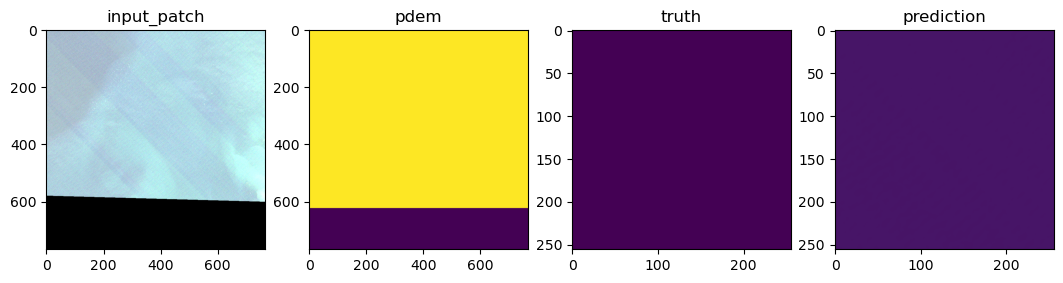

Ep181: tra-> Loss:0.003,Oa:0.977,Miou:0.954, val-> Loss:0.010,Oa:0.905, Miou:0.845,time:2.7s
Ep182: tra-> Loss:0.004,Oa:0.976,Miou:0.943, val-> Loss:0.006,Oa:0.926, Miou:0.853,time:2.7s
Ep183: tra-> Loss:0.003,Oa:0.972,Miou:0.947, val-> Loss:0.005,Oa:0.920, Miou:0.864,time:2.7s
Ep184: tra-> Loss:0.002,Oa:0.975,Miou:0.951, val-> Loss:0.005,Oa:0.938, Miou:0.881,time:2.8s
Ep185: tra-> Loss:0.002,Oa:0.982,Miou:0.950, val-> Loss:0.005,Oa:0.936, Miou:0.873,time:2.9s
Ep186: tra-> Loss:0.002,Oa:0.979,Miou:0.948, val-> Loss:0.005,Oa:0.936, Miou:0.878,time:2.8s
Ep187: tra-> Loss:0.002,Oa:0.981,Miou:0.958, val-> Loss:0.005,Oa:0.937, Miou:0.879,time:2.9s
Ep188: tra-> Loss:0.003,Oa:0.975,Miou:0.931, val-> Loss:0.005,Oa:0.930, Miou:0.875,time:2.9s
Ep189: tra-> Loss:0.003,Oa:0.961,Miou:0.939, val-> Loss:0.006,Oa:0.908, Miou:0.845,time:2.8s
Ep190: tra-> Loss:0.003,Oa:0.979,Miou:0.955, val-> Loss:0.006,Oa:0.920, Miou:0.854,time:2.7s
Ep191: tra-> Loss:0.002,Oa:0.983,Miou:0.959, val-> Loss:0.005,Oa:0.922

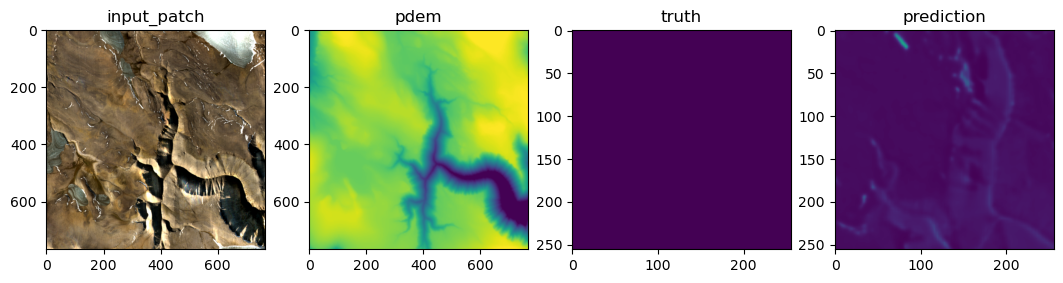

In [10]:
device = torch.device('cuda:1') 
metrics = train_loops(model=model, 
                epoches=200,  
                loss_fn=loss_focal,  
                optimizer=optimizer,  
                tra_loader=tra_loader,    
                val_loader=val_loader,  
                lr_scheduler=lr_scheduler,
                patch_size=patch_size,
                patch_resize=None,
                device=device)  


In [11]:
# # model saving
# model_name = 'unet'
# # net_name = 'deeplabv3plus'
# # # net_name = 'deeplabv3plus_mb2'
# path_save = f'model/trained/patch_{patch_size}/{model_name}_weights_2.pth'
# # path_save = f'model/trained/{model_name}_{patch_size}/{model_name}_weights.pth'
# torch.save(model.state_dict(), path_save)   ## save weights of the trained model 
# # # model.load_state_dict(torch.load(path_save, weights_only=True))  # load the weights of the trained model
# # # ## metrics saving
# # path_metrics = f'model/trained/{model_name}_{patch_size}/{model_name}_metrics.csv'
# path_metrics = f'model/trained/patch_{patch_size}/{model_name}_metrics_2.csv'
# metrics_df = pd.DataFrame(metrics)
# metrics_df.to_csv(path_metrics, index=False, sep=',')
